<a href="https://colab.research.google.com/github/harimadhavan2000/AI2_P2/blob/dev%2Fhari/Univ_ai_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 35.4 MB/s 


In [2]:
#RUN THIS CELL
import os
import pathlib

working_dir = pathlib.Path().absolute()
# Uncomment the line below to help debug if the path to included images don't show
#print(working_dir)
os.chdir(working_dir)

In [3]:
import os
import certifi
import urllib3  # For handling https certificate verification 
import requests
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import convolve2d
import scipy.ndimage as ndimage
import subprocess
from pathlib import Path
from PIL import Image
from matplotlib import cm
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from keras.utils.layer_utils import count_params  
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD

In [5]:
# Enable/Disable Eager Execution

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Pysical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/datac_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.9.2
keras version 2.9.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
GPU Available:  []
All Pysical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/archive_1.zip" -d "/content/Data_extract/"

In [47]:
path = "/content/Data_extract"
path_ls = os.listdir(path)
path_ls

['validation_another', 'test', 'test_another', 'train_another']

### Assigning the data with Tabluar form for the **EDA**

In [37]:
file_df = Path(path)
file_path = pd.DataFrame({'Path': list(file_df.glob('**/*.jp*g'))})
file_path["Label"] = file_path['Path'].map(lambda x: x.parent.stem)
file_path["Split"] = file_path['Path'].map(lambda x: x.parent.parent.stem)
file_path.sample(5)

,Path,Label,Split
474,/content/Data_extract/validation_another/damag...,damage,validation_another
1184,/content/Data_extract/validation_another/no_da...,no_damage,validation_another
8839,/content/Data_extract/test_another/damage/-96....,damage,test_another
10692,/content/Data_extract/test_another/damage/-96....,damage,test_another
2983,/content/Data_extract/test/damage/-95.10308_29...,damage,test


In [147]:
sns.set_theme()

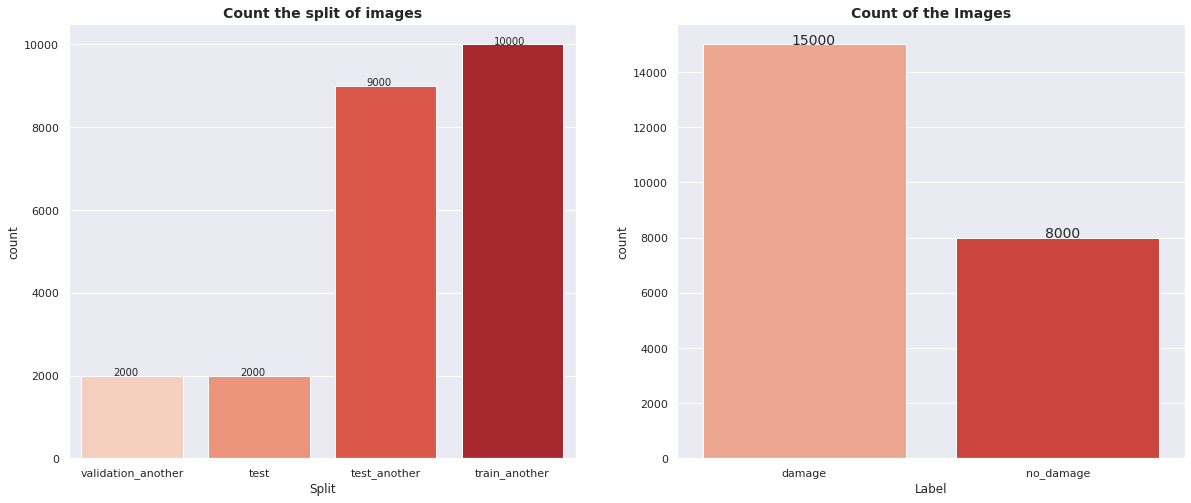

In [148]:
#Creating subplots for the 2 projects of data
fig, ax = plt.subplots(1,2,figsize =(20,8))

#creating countplot in seaborn x is indecanting the data to be plotted
sns.countplot(data = file_path,x = "Split", palette = "Reds", ax= ax[0])
sns.countplot(data= file_path, x = "Label", palette = "Reds", ax= ax[1])

#creaing annotations for both the plots
for p in ax[0].patches:
   ax[0].annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()), fontsize=10)

for p in ax[1].patches:
   ax[1].annotate('{}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()), fontsize=14,)

#Setting the title for plots
ax[0].set_title('Count the split of images', fontsize=14, fontweight='bold')
ax[1].set_title('Count of the Images', fontsize=14, fontweight='bold')

fig.show()

Here this plot shows the complete data in dataset.Their are **15000 damged** and **8000 undamaged** buildings due to hurricane. so, we have a total of **23000** buildings are have been impacted due to hurricane  

### Indentifying the pattern of the hurricane thorught the cooridents in the image labels.

In [149]:
#creating the necessary varibales for the plot
sat = pd.DataFrame({'Path': list(Path(path).glob('**/*.jp*g'))})

sat['location'] = sat['Path'].map(lambda x: x.stem)
sat['Damage'] = sat['Path'].map(lambda x: x.parent.stem)
sat['lon'] = sat['location'].map(lambda x:  float(x.split('_')[0]))
sat['lat'] = sat['location'].map(lambda x:  float(x.split('_')[-1]))

sat

,Path,location,Damage,lon,lat
0,/content/Data_extract/validation_another/damag...,-95.59579699999999_29.766398,damage,-95.595797,29.766398
1,/content/Data_extract/validation_another/damag...,-95.20055_29.537113,damage,-95.200550,29.537113
2,/content/Data_extract/validation_another/damag...,-95.271241_29.604366,damage,-95.271241,29.604366
3,/content/Data_extract/validation_another/damag...,-95.55545699999999_29.762396999999996,damage,-95.555457,29.762397
4,/content/Data_extract/validation_another/damag...,-95.63904000000001_29.846185,damage,-95.639040,29.846185
...,...,...,...,...,...
22995,/content/Data_extract/train_another/no_damage/...,-95.224884_30.010064,no_damage,-95.224884,30.010064
22996,/content/Data_extract/train_another/no_damage/...,-95.178731_30.040072,no_damage,-95.178731,30.040072
22997,/content/Data_extract/train_another/no_damage/...,-95.073651_29.829771,no_damage,-95.073651,29.829771
22998,/content/Data_extract/train_another/no_damage/...,-95.271402_29.60512,no_damage,-95.271402,29.605120


Text(0.5, 1.0, 'Hurricane_presence from the eagle view')

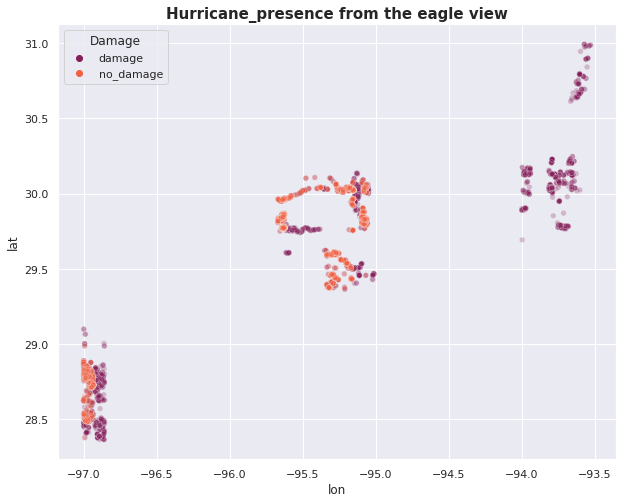

In [193]:
#Creating Plots
fig, ax = plt.subplots(figsize =(10,8))

#Giving the variables for the size of the data
s = 30

#Giving the variabke for the brightness if the count
alpha = 0.25
#Scatterplotting the data with the help of coordinats
sns.scatterplot(data = sat, x = "lon", y = "lat", hue = "Damage", palette = "rocket",s=s, 
                alpha=alpha).set_title("Hurricane_presence from the eagle view", fontsize = 15, fontweight='bold')

By the above plot can see that from longitute -95.5 to -90.0 the impact was very high and we are having rekative amount of damage in -97.0 as well also.

Text(0.5, 1.0, 'Hurricane has not impacted and safe buildings')

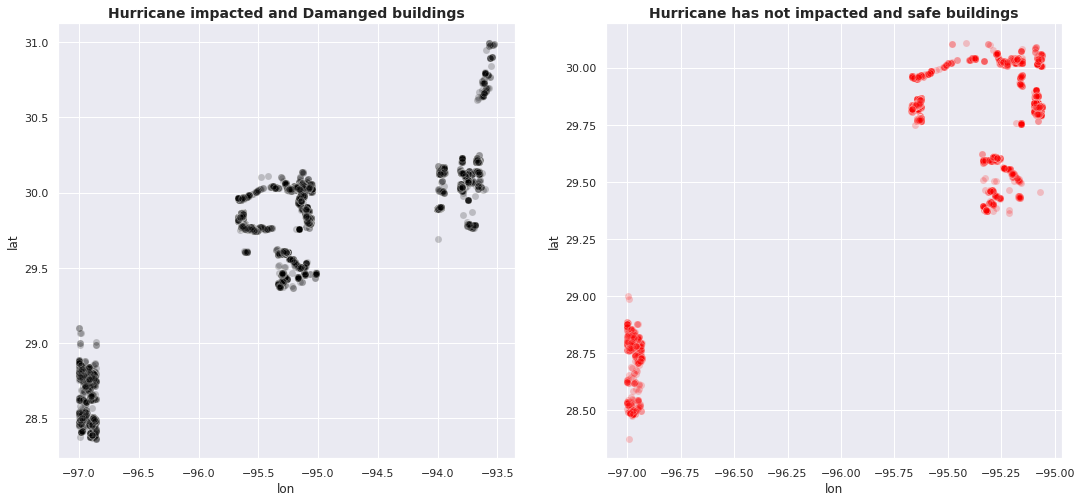

In [192]:
#Creating Plots for damaged and safe 
fig, ax = plt.subplots(1,2,figsize =(18,8))

#Giving the variables for the size of the data
s = 50

#Giving the variabke for the brightness if the count
alpha = 0.20


#Scatterplotting the data with the help of coordinats
sns.scatterplot(data = sat[sat["Damage"] == "damage"], x = "lon", y = "lat",color = "Black", palette = "rocket",s=s, alpha=alpha,
                ax = ax[0]).set_title("Hurricane impacted and Damanged buildings", fontsize = 14, fontweight = 'bold')

sns.scatterplot(data = sat[sat["Damage"] == "no_damage"], x = "lon", y = "lat", color='Red', palette = "rocket",s=s, alpha=alpha,
                ax = ax[1]).set_title("Hurricane has not impacted and safe buildings", fontsize = 14, fontweight = 'bold')

The plot_1 shows the Damaged stutures by this plt we can say, their are 3 main zones that has been impacted.

---
Zone_A:

  The cluster enivorment of lon_range(-97.0) lat_range(28, 29.0) is having strong impact of the hurraicane.

---

Zone_B:
  THe cluster enivornment of lon_range(-95.8, -95.0) lat_range(29.3, 30.1) is having a sprical impact.

---

Zone_c:
  The cluster enovronment if lon_range(-94.0, -93.5) lat_range(29.8, 31.0) is having a veritcal impact but the it is not severe impact when compared to above two zones.


The plot_2 shows the Not-Damaged (or) Safe stutures by this plt we can say, their are 2 zones that was safe from hurricane.

---
Zone_A:
  The Amount of is destruction that happpend by the hurricane is really stroung, but the due to dense network of sturcuture in the zone range of lat_range(-97.0) lon_range(28.5, 28.8) has reduced the imapact because it's having less room to flow of air through them.

---
Zone_B:
  This probably the less impacted zone of all.The cluster of lon_range(-95.75, 95.0) lat_range(29.25, 30.3) is comparatively less effected





